This notebook investigates whether training factor models incrementally is faster and more robust than training them from scratch

In [1]:
import numpy as np
import torch
import pyro
import pyro.optim
from pyro.infer import SVI, Trace_ELBO
from torch.distributions import constraints
from pyro import distributions as dst
from collections import defaultdict
import matplotlib.pylab as plt

In [2]:
def factorAnalysis(X):
    N, D = X.shape
    K = D
    locloc = 0.
    locscale = 1.
    scaleloc = 0.
    scalescale = 1.
    cov_factor_loc = torch.zeros(K,D)
    cov_factor_scale = torch.ones(K,D)*10
    with pyro.plate('D', D):
        loc = pyro.sample('loc', dst.Normal(locloc, locscale))
        cov_diag = pyro.sample('scale', dst.LogNormal(scaleloc, scalescale))
        with pyro.plate('K', K):
            cov_factor = pyro.sample('cov_factor', dst.Normal(cov_factor_loc,cov_factor_scale))
        cov_factor = cov_factor.transpose(0,1)
    with pyro.plate('N', N):
        X = pyro.sample('obs', dst.LowRankMultivariateNormal(loc, cov_factor=cov_factor, cov_diag=cov_diag))
    return X

In [3]:
N = 1000
D = 5
data = factorAnalysis(np.ones((N,D)))

In [4]:
initial_hyperparameters = (1,torch.zeros(D),torch.ones(D),torch.zeros(D),torch.ones(D),torch.zeros(1,D),torch.ones(1,D)*10)

In [5]:
def model(X, hyperparameters = initial_hyperparameters):
    N, D = X.shape
    K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = hyperparameters
    with pyro.plate('D', D):
        loc = pyro.sample('loc', dst.Normal(locloc, locscale))
        cov_diag = pyro.sample('scale', dst.LogNormal(scaleloc, scalescale))
        with pyro.plate('K', K):
            cov_factor = pyro.sample('cov_factor', dst.Normal(cov_factor_loc,cov_factor_scale))
        cov_factor = cov_factor.transpose(0,1)
    with pyro.plate('N', N):
        X = pyro.sample('obs', dst.LowRankMultivariateNormal(loc, cov_factor=cov_factor, cov_diag=cov_diag))
    return X

In [6]:
def guide(X, hyperparameters):
    K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = hyperparameters
    with pyro.plate('D', D, dim=-1):
        # get initial parameter values from parent
        # define parameters, clone initial parameter values from supplied hyperparameters, to avoid updating them
        loc_loc = pyro.param('loc_loc', locloc.clone())
        loc_scale = pyro.param('loc_scale', locscale.clone(), constraint=constraints.positive)
        cov_diag_loc = pyro.param('scale_loc', scaleloc.clone())
        cov_diag_scale = pyro.param('scale_scale', scalescale.clone(), constraint=constraints.positive)
        # sample variables
        loc = pyro.sample('loc', dst.Normal(loc_loc,loc_scale))
        with pyro.plate('K', K, dim=-2):
            cov_factor_loc = pyro.param('cov_factor_loc', cov_factor_loc.clone())
            cov_factor_scale = pyro.param('cov_factor_scale', cov_factor_scale.clone(), constraint=constraints.positive)
            cov_factor = pyro.sample('cov_factor', dst.Normal(cov_factor_loc, cov_factor_scale))
        cov_factor = cov_factor.transpose(0,1)
        cov_diag = pyro.sample('scale', dst.LogNormal(cov_diag_loc, cov_diag_scale))
    return loc, cov_factor, cov_diag

In [7]:
initial_hyperparameters

(1,
 tensor([0., 0., 0., 0., 0.]),
 tensor([1., 1., 1., 1., 1.]),
 tensor([0., 0., 0., 0., 0.]),
 tensor([1., 1., 1., 1., 1.]),
 tensor([[0., 0., 0., 0., 0.]]),
 tensor([[10., 10., 10., 10., 10.]]))

In [8]:
track_params = True
def per_param_callable(module_name, param_name):
    return {"lr": 0.01, 'betas': [0.9, 0.99]}

def initialize(seed, hyperparameters):
    # evaluate loss on a randomly initialized parameter-set 
    pyro.set_rng_seed(seed)
    loss = svi.loss(conditioned_model, guide, data, hyperparameters)
    return loss

In [9]:
conditioned_model = pyro.condition(model, data = {'obs': data})
optim = pyro.optim.Adam(per_param_callable)
elbo = Trace_ELBO()
svi = SVI(conditioned_model, guide, optim, loss=elbo)

In [10]:
initial_hyperparameters

(1,
 tensor([0., 0., 0., 0., 0.]),
 tensor([1., 1., 1., 1., 1.]),
 tensor([0., 0., 0., 0., 0.]),
 tensor([1., 1., 1., 1., 1.]),
 tensor([[0., 0., 0., 0., 0.]]),
 tensor([[10., 10., 10., 10., 10.]]))

In [11]:
loss, seed = min((initialize(seed, initial_hyperparameters), seed) for seed in range(100))
# Register hooks to monitor gradient norms.
losses = []
gradient_norms = defaultdict(list)
if track_params:
    param_history = dict({k:v.unsqueeze(0) for k,v in pyro.get_param_store().items()})
# register gradient hooks for monitoring
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

In [12]:
# optimize
for i in range(800):
    loss = svi.step(data, initial_hyperparameters)
    losses.append(loss)
    if track_params:
    # warning: this builds the param_history dict from scratch in every iteration
        param_history = {k:torch.cat([param_history[k],v.unsqueeze(0)],dim=0) for k,v in pyro.get_param_store().items()}
        print('.' if i % 100 else '\n', end='')
params = pyro.get_param_store()


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

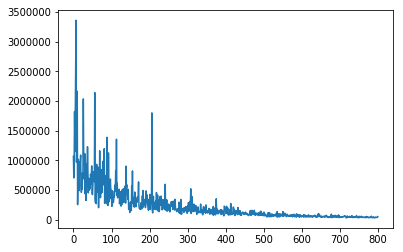

In [14]:
plt.plot(losses)

In [15]:
# use built-in params functions to smoothly handle constraints
transferred_hyperparameters = tuple([params.get_param(k).repeat(2,1) if k.startswith('cov') else params.get_param(k) for k in params.get_all_param_names()])

In [16]:
transferred_hyperparameters = (2,) + transferred_hyperparameters

In [17]:
initial_hyperparameters

(1,
 tensor([0., 0., 0., 0., 0.]),
 tensor([1., 1., 1., 1., 1.]),
 tensor([0., 0., 0., 0., 0.]),
 tensor([1., 1., 1., 1., 1.]),
 tensor([[0., 0., 0., 0., 0.]]),
 tensor([[10., 10., 10., 10., 10.]]))

In [18]:
transferred_hyperparameters

(2,
 tensor([-0.9897, -0.2333, -0.4086, -0.3095,  1.6169], requires_grad=True),
 tensor([0.3490, 0.3080, 0.3117, 0.3371, 0.3922], grad_fn=<AddBackward0>),
 tensor([3.2266, 3.4501, 3.6744, 3.1198, 3.3022], requires_grad=True),
 tensor([0.3993, 0.3812, 0.4013, 0.5450, 0.4712], grad_fn=<AddBackward0>),
 tensor([[-0.0358,  0.0655,  0.0372,  0.1348, -0.0965],
         [-0.0358,  0.0655,  0.0372,  0.1348, -0.0965]],
        grad_fn=<RepeatBackward>),
 tensor([[ 3.0931,  4.0083,  5.9948, 32.2687, 18.3924],
         [ 3.0931,  4.0083,  5.9948, 32.2687, 18.3924]],
        grad_fn=<RepeatBackward>))

In [22]:
conditioned_model = pyro.condition(model, data = {'obs': data})
optim = pyro.optim.Adam(per_param_callable)
elbo = Trace_ELBO()
svi = SVI(conditioned_model, guide, optim, loss=elbo)

loss, seed = min((initialize(seed, transferred_hyperparameters), seed) for seed in range(100))
# Register hooks to monitor gradient norms.
losses = []
gradient_norms = defaultdict(list)
if track_params:
    param_history = dict({k:v.unsqueeze(0) for k,v in pyro.get_param_store().items()})
# register gradient hooks for monitoring
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

In [24]:
# optimize
for i in range(800):
    loss = svi.step(data, transferred_hyperparameters)
    losses.append(loss)
    if track_params:
    # warning: this builds the param_history dict from scratch in every iteration
        param_history = {k:torch.cat([param_history[k],v.unsqueeze(0)],dim=0) for k,v in pyro.get_param_store().items()}
        print('.' if i % 100 else '\n', end='')
params = pyro.get_param_store()

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.